In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

/home/lfektn/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/lfektn/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from travwave.equations import Equation
from travwave.discretization import Discretization
from travwave.boundary.mean import Mean

In [3]:
class Babenko(Equation):
    """
    The equation type is : -\mu*u + 1/2*u^2 + Du= 0
                   where : D = (Br Dx)^{-1}, Br - from Kuznetsov
    """
    def degree(self):
        return 2

    def compute_kernel(self, k, r=.9):
        BrDx = np.ones_like(k) # arbitrary value for k == 0
        BrDx[1:] = 1/(np.abs(k[1:])+1/(1/r**(2*k[1:]) - 1))
        return BrDx
        
    def flux(self, u):
        return 0.5*np.power(u, 2)

    def flux_prime(self, u):
        return u


In [4]:
class Babenko_inverse(Equation):
    """
    The equation type is : -\mu*u + 1/2*u^2 + Du= 0
                   where : D = (Br Dx)^{-1}, Br - from Kuznetsov
    """
    def degree(self):
        return 2

    def compute_kernel(self, k, r=.9):
        BrDx = np.ones_like(k) # arbitrary value for k == 0
        BrDx[1:] = (np.abs(k[1:])+1/(1/r**(2*k[1:]) - 1))
        return BrDx
        
    def flux(self, u):
        return 0.5*np.power(u, 2)

    def flux_prime(self, u):
        return u


In [5]:
class Kuznetsov(Babenko):
        
#     def compute_kernel(self, k, r=.5):
#         BrDx = np.ones_like(k) # arbitrary value for k == 0
#         BrDx[1:] = 1/(np.abs(k[1:])+1/(1/r**(2*k[1:]) - 1))
#         return BrDx
    
    def flux(self, u):
        size = len(u)
        d = Discretization(equation=Babenko(self.length), size=size)
        dinv = Discretization(equation=Babenko_inverse(self.length), size=size)
        return 0.5*np.power(u, 2) + d.apply_operator( u * dinv.apply_operator(u))
   

In [127]:
class SuperMean(Mean):
    """
    """
    def enforce(self, wave, variables, parameters):
        integral = super(SuperMean, self).enforce(wave, variables, parameters)      
        size = len(wave)
        dinv = Discretization(equation=Babenko_inverse(np.pi), size=size)
        u = wave
        func = u * dinv.apply_operator(u)
        extra = np.sum(func)
        return integral + extra

    def variables_num(self):
        return 1


In [128]:
#import mpld3; mpld3.enable_notebook() # this line enable some interactivity on plots
from matplotlib import pyplot as plt
import numpy as np

from __future__ import division
from travwave.diagram import *
from travwave.boundary import *
from travwave.equations import *
from travwave.dynamic import *

L = np.pi
eq_object = Kuznetsov(L)
boundary_condition = SuperMean()
Ngrid = 256
bd = BifurcationDiagram(eq_object,boundary_condition)
bd.initialize(step=0.0001)

n = 5
bd.navigation.run(n)   #Navigation algorithm works only up to n = 20.



In [153]:
bd.navigation.run(15)
len(bd.navigation)

296

(0.185, 0.19, 0.0, 0.025000000000000001)

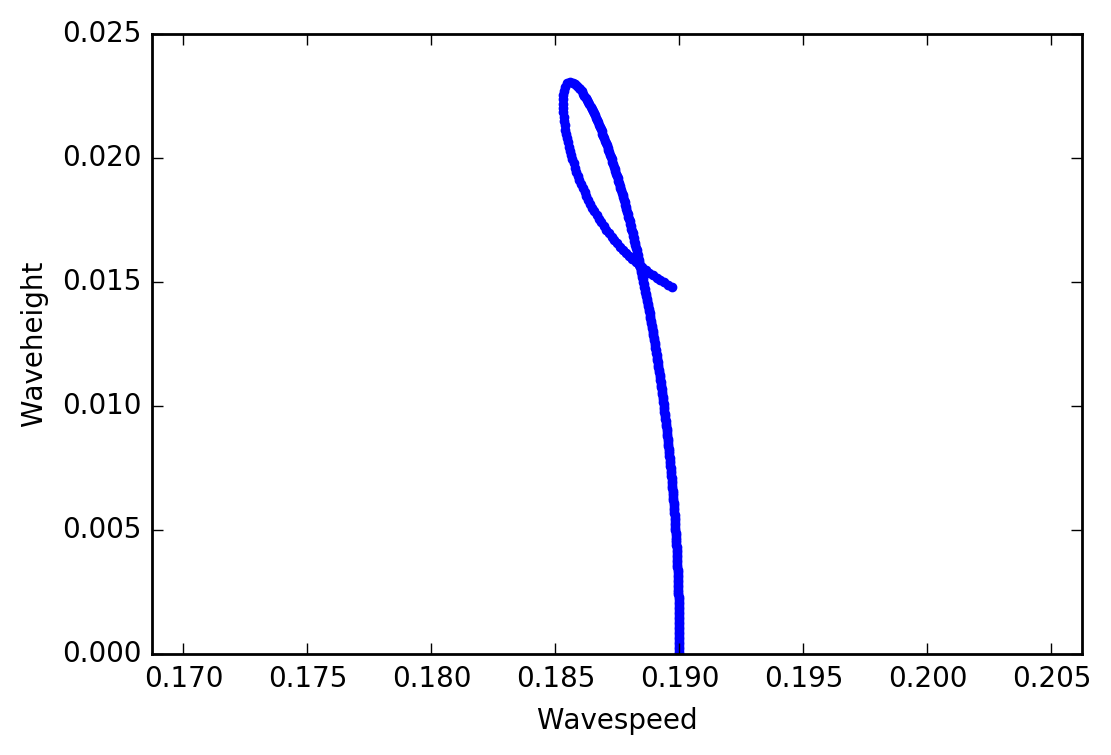

In [154]:
bd.plot_diagram()
plt.axis('equal')

(0.18969340549648217, 0.014813655329162758)


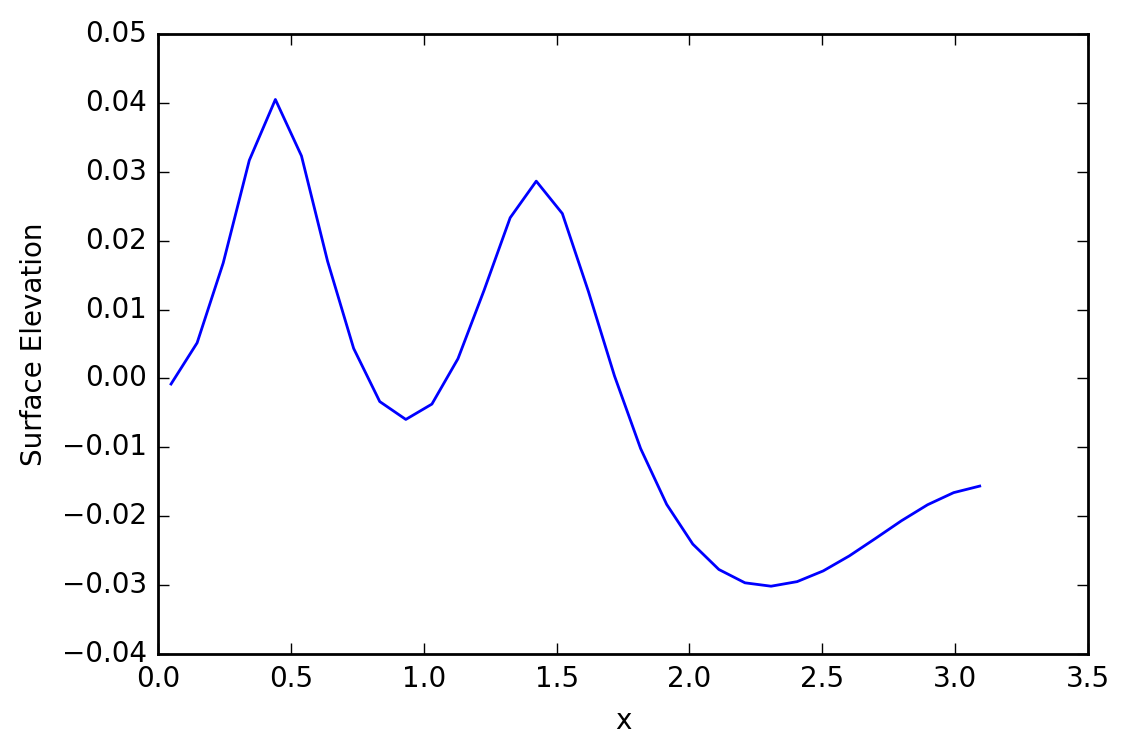

In [155]:
print( bd.navigation[-1]['current'] )
bd.plot_solution(bd.navigation[-1]['solution'])

In [122]:
u_, B, p = bd.navigation.refine_at(128, index=10)

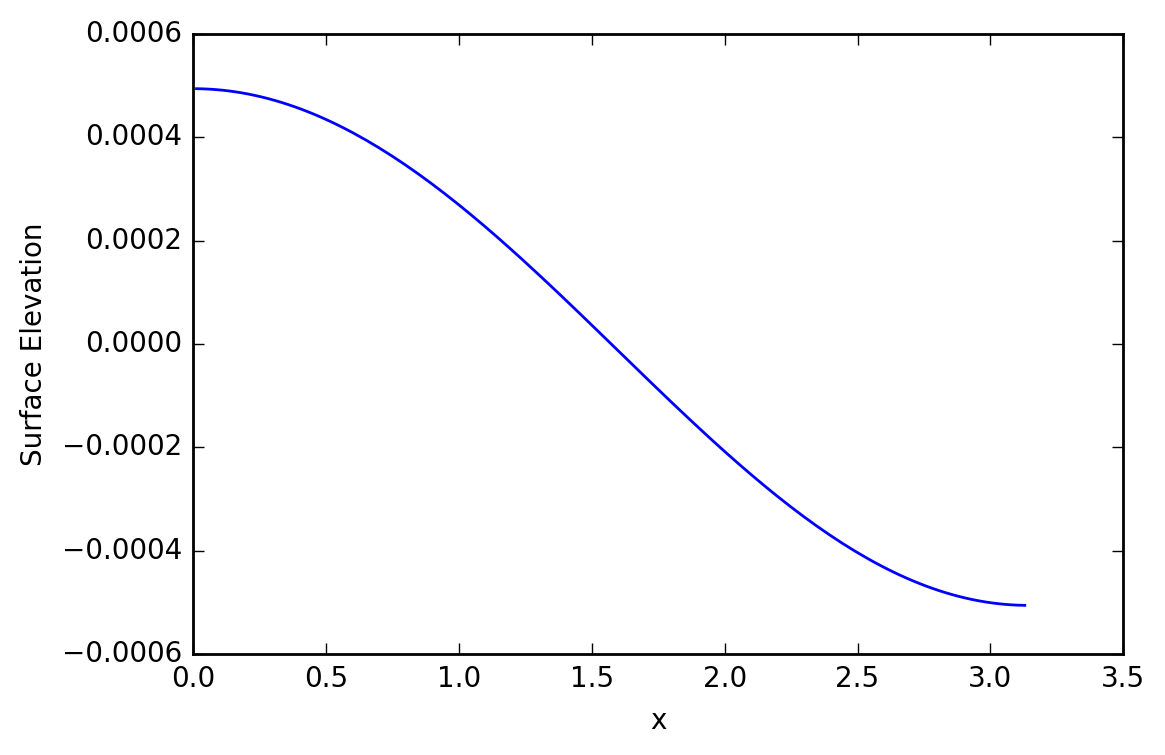

In [123]:
bd.plot_solution(u_)